In [9]:
%matplotlib inline
from __future__ import print_function
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import random

In [10]:
x = np.array([0, 1, 2, 3])
y = np.array([-1, 0.2, 0.9, 2.1])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y)[0]
print(m,c)

1.0 -0.95


(array([ 1.  , -0.95]), array([ 0.05]), 2, array([ 4.10003045,  1.09075677]))

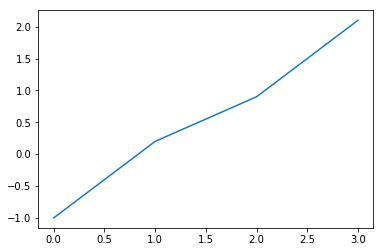

In [11]:
plt.plot(x,y)
np.linalg.lstsq(A, y)

In [12]:
help(np.linalg.lstsq)

Help on function lstsq in module numpy.linalg.linalg:

lstsq(a, b, rcond=-1)
    Return the least-squares solution to a linear matrix equation.
    
    Solves the equation `a x = b` by computing a vector `x` that
    minimizes the Euclidean 2-norm `|| b - a x ||^2`.  The equation may
    be under-, well-, or over- determined (i.e., the number of
    linearly independent rows of `a` can be less than, equal to, or
    greater than its number of linearly independent columns).  If `a`
    is square and of full rank, then `x` (but for round-off error) is
    the "exact" solution of the equation.
    
    Parameters
    ----------
    a : (M, N) array_like
        "Coefficient" matrix.
    b : {(M,), (M, K)} array_like
        Ordinate or "dependent variable" values. If `b` is two-dimensional,
        the least-squares solution is calculated for each of the `K` columns
        of `b`.
    rcond : float, optional
        Cut-off ratio for small singular values of `a`.
        For the purpose

Calibration object, used for storing and applying the calibration parameters.
Computes the Zero G levels, Sensitivity, Scale factor Matrix and the
bias vector of a MEMS accelerometer.

The procedure exploits the fact that, in static conditions, the
modulus of the accelerometer output vector matches that of the
gravity acceleration. The calibration model incorporates the bias
and scale factor for each axis and the cross-axis symmetrical
factors. The parameters are computed through Gauss-Newton
nonlinear optimization.

The mathematical model used is  $a = M(r - b)$
where $M$ and $b$ are scale factor matrix and
bias vector respectively and $r$ is the raw accelerometer
reading.
    
\begin{eqnarray}
M = \begin{bmatrix}
        M_{xx} & M_{xy} & M_{xz} \\
        M_{yx} & M_{yy} & M_{yz} \\
        M_{zx} & M_{zy} & M_{zz}
    \end{bmatrix} \\
b = \begin{bmatrix}
        b_{x} \\
        b_{y} \\
        b_{z}
    \end{bmatrix} \\
        M_{xy} = M_{yx} \\
        M_{xz} = M_{zx} \\
        M_{yz} = M_{zy} \\
\end{eqnarray}

The diagonal elements of M represent the scale factors along the
three axes, whereas the other elements of M are called cross-axis
factors. These terms allow describing both the axes’ misalignment
and the crosstalk effect between different channels caused
by the sensor electronics. In an ideal world, $M = I$ and
$B = \mathbb{0}$.

In [13]:
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import absolute_import

import copy

import six
import numpy as np

# Version information.
# __version__ = '0.2.0'
# version = __version__  # backwards compatibility name
# version_info = (0, 2, 0)


class Calibraxis(object):
    """Calibration object, used for storing and applying the
    calibration parameters.

    Computes the Zero G levels, Sensitivity, Scale factor Matrix and the
    bias vector of a MEMS accelerometer.

    The procedure exploits the fact that, in static conditions, the
    modulus of the accelerometer output vector matches that of the
    gravity acceleration. The calibration model incorporates the bias
    and scale factor for each axis and the cross-axis symmetrical
    factors. The parameters are computed through Gauss-Newton
    nonlinear optimization.

    The mathematical model used is  :math:`a = M(r - b)`
    where :math:`M` and :math:`b` are scale factor matrix and
    bias vector respectively and :math:`r` is the raw accelerometer
    reading.

    .. math::

        M = \begin{matrix}
                M_{xx} & M_{xy} & M_{xz} \\
                M_{yx} & M_{yy} & M_{yz} \\
                M_{zx} & M_{zy} & M_{zz}
            \end{matrix}

        b = \begin{matrix}
                b_{x} \\
                b_{y} \\
                b_{z}
            \end{matrix}

    where

    .. math::

        M_{xy} = M_{yx}

        M_{xz} = M_{zx}

        M_{yz} = M_{zy}.

    The diagonal elements of M represent the scale factors along the
    three axes, whereas the other elements of M are called cross-axis
    factors. These terms allow describing both the axes’ misalignment
    and the crosstalk effect between different channels caused
    by the sensor electronics. In an ideal world, :math:`M = I` and
    :math:`B = \mathbb{0}`.

    Reference:
    Iuri Frosio, Federico Pedersini, N. Alberto Borghese
    "Autocalibration of MEMS Accelerometers"
    IEEE TRANSACTIONS ON INSTRUMENTATION AND MEASUREMENT, VOL. 58, NO. 6, JUNE 2009

    This is a Python reimplementation of the Matlab routines found at
    `Matlab File Central <http://se.mathworks.com/matlabcentral/fileexchange/
    33252-mems-accelerometer-calibration-using-gauss-newton-method>`_.

    :param bool verbose: Print optimization progress data.

    """

    def __init__(self, verbose=False):

        self._points = []
        self._verbose = verbose

        # Accelerometer calibration parameters.
        self._calibration_points = []
        self._calibration_errors = None

        self.bias_vector = None
        self.scale_factor_matrix = None

    def add_points(self, points):
        """Add point(s) to the calibration procedure.

        :param list, tuple, numpy.ndarray points: The point(s) to add to the
            calibration point storage.

        """
        if isinstance(points, (list, tuple)):
            if len(points) > 0:
                if isinstance(points[0], (list, tuple, np.ndarray)):
                    # Multiple points sent as list of lists.
                    for p in points:
                        self._calibration_points.append(copy.deepcopy(p))
                else:
                    # Assume single point sent in as list/tuple/array.
                    self._calibration_points.append(copy.deepcopy(points))
            else:
                # Empty list/tuple. Skip.
                pass
        elif isinstance(points, np.ndarray):
            if points.ndim > 1:
                for p in points:
                    self._calibration_points.append(p.copy())
            elif points.ndim == 1:
                self._calibration_points.append(points.copy())

    def calibrate_accelerometer(self):
        """Perform the calibration of accelerometer using the
        stored points.
        """
        points = np.array(self._calibration_points)
        self._perform_accelerometer_calibration_optimisation(points)

    def _perform_accelerometer_calibration_optimisation(self, points):
        """Perform the Gauss-Newton optimisation for parameters."""
        nbr_points = len(points)
        if nbr_points < 9:
            raise ValueError(
                'Need at least 9 measurements for the calibration procedure!')

        def error_function(M_mat, b_vec, y):
            """Optimisation error function for a point.

            :param numpy.ndarray M_mat: The scale factor matrix
                of this iteration.
            :param numpy.ndarray b_vec: The zero-g offset vector
                of this iteration.
            :param numpy.ndarray y: The point ot estimate error for.
            :return: The square sum of the error of this point.
            :rtype: float

            """
            return float(np.sum((M_mat.dot((y - b_vec)) ** 2)) - 1)

        def calculate_jacobian(M_mat, b_vec, point):
            """Calculate the Jacobian for a point.

            :param numpy.ndarray M_mat: The scale factor matrix
                of this iteration.
            :param numpy.ndarray b_vec: The zero-g offset vector
                of this iteration.
            :param numpy.ndarray y: The point ot estimate error for.
            :return: The square sum of the error of this point.
            :rtype: float

            """
            jac = np.zeros((9,), 'float')

            jac[0] = 2 * (b_vec[0] - point[0]) * (
                M_mat[0, 0] * (b_vec[0] - point[0]) + M_mat[0, 1] * (
                b_vec[1] - point[1]) + M_mat[0, 2] * (
                    b_vec[2] - point[2]))
            jac[1] = 2 * (b_vec[1] - point[1]) * (
                M_mat[0, 0] * (b_vec[0] - point[0]) + M_mat[0, 1] * (
                b_vec[1] - point[1]) + M_mat[0, 2] * (
                    b_vec[2] - point[2])) + 2 * (b_vec[0] - point[0]) * (
                M_mat[0, 1] * (b_vec[0] - point[0]) + M_mat[1, 1] * (
                b_vec[1] - point[1]) + M_mat[1, 2] * (
                    b_vec[2] - point[2]))
            jac[2] = 2 * (b_vec[0] - point[0]) * (
                M_mat[0, 2] * (b_vec[0] - point[0]) + M_mat[1, 2] * (
                b_vec[1] - point[1]) + M_mat[2, 2] * (
                    b_vec[2] - point[2])) + 2 * (b_vec[2] - point[2]) * (
                M_mat[0, 0] * (b_vec[0] - point[0]) + M_mat[0, 1] * (
                b_vec[1] - point[1]) + M_mat[0, 2] * (
                    b_vec[2] - point[2]))
            jac[3] = 2 * (b_vec[1] - point[1]) * (
                M_mat[0, 1] * (b_vec[0] - point[0]) + M_mat[1, 1] * (
                b_vec[1] - point[1]) + M_mat[1, 2] * (
                    b_vec[2] - point[2]))
            jac[4] = 2 * (b_vec[1] - point[1]) * (
                M_mat[0, 2] * (b_vec[0] - point[0]) + M_mat[1, 2] * (
                b_vec[1] - point[1]) + M_mat[2, 2] * (
                    b_vec[2] - point[2])) + 2 * (b_vec[2] - point[2]) * (
                M_mat[0, 1] * (b_vec[0] - point[0]) + M_mat[1, 1] * (
                b_vec[1] - point[1]) + M_mat[1, 2] * (
                    b_vec[2] - point[2]))
            jac[5] = 2 * (b_vec[2] - point[2]) * (
                M_mat[0, 2] * (b_vec[0] - point[0]) + M_mat[1, 2] * (
                b_vec[1] - point[1]) + M_mat[2, 2] * (
                    b_vec[2] - point[2]))
            jac[6] = 2 * M_mat[0, 0] * (
                M_mat[0, 0] * (b_vec[0] - point[0]) + M_mat[0, 1] * (
                b_vec[1] - point[1]) + M_mat[0, 2] * (
                    b_vec[2] - point[2])) + 2 * M_mat[0, 1] * (
                M_mat[0, 1] * (b_vec[0] - point[0]) + M_mat[1, 1] * (
                b_vec[1] - point[1]) + M_mat[1, 2] * (
                    b_vec[2] - point[2])) + 2 * M_mat[0, 2] * (
                M_mat[0, 2] * (b_vec[0] - point[0]) + M_mat[1, 2] * (
                b_vec[1] - point[1]) + M_mat[2, 2] * (
                    b_vec[2] - point[2]))
            jac[7] = 2 * M_mat[0, 1] * (
                M_mat[0, 0] * (b_vec[0] - point[0]) + M_mat[0, 1] * (
                b_vec[1] - point[1]) + M_mat[0, 2] * (
                    b_vec[2] - point[2])) + 2 * M_mat[1, 1] * (
                M_mat[0, 1] * (b_vec[0] - point[0]) + M_mat[1, 1] * (
                b_vec[1] - point[1]) + M_mat[1, 2] * (
                    b_vec[2] - point[2])) + 2 * M_mat[1, 2] * (
                M_mat[0, 2] * (b_vec[0] - point[0]) + M_mat[1, 2] * (
                b_vec[1] - point[1]) + M_mat[2, 2] * (
                    b_vec[2] - point[2]))
            jac[8] = 2 * M_mat[0, 2] * (
                M_mat[0, 0] * (b_vec[0] - point[0]) + M_mat[0, 1] * (
                b_vec[1] - point[1]) + M_mat[0, 2] * (
                    b_vec[2] - point[2])) + 2 * M_mat[1, 2] * (
                M_mat[0, 1] * (b_vec[0] - point[0]) + M_mat[1, 1] * (
                b_vec[1] - point[1]) + M_mat[1, 2] * (
                    b_vec[2] - point[2])) + 2 * M_mat[2, 2] * (
                M_mat[0, 2] * (b_vec[0] - point[0]) + M_mat[1, 2] * (
                b_vec[1] - point[1]) + M_mat[2, 2] * (
                    b_vec[2] - point[2]))

            return jac

        def optvec_to_M_and_b(v):
            """
            Convenience method for moving between optimisation
            vector and correct lin.alg. formulation.
            """
            return (np.array([[v[0], v[1], v[2]],
                              [v[1], v[3], v[4]],
                              [v[2], v[4], v[5]]]),
                    v[6:].copy())

        gain = 1  # Damping Gain - Start with 1
        damping = 0.01    # Damping parameter - has to be less than 1.
        tolerance = 1e-12
        R_prior = 100000
        self._calibration_errors = []
        nbr_iterations = 200

        # Initial Guess values of M and b.
        if self.bias_vector is not None:
            # Recalibration using prior optimization results.
            x = np.array([self.scale_factor_matrix[0, 0],
                          self.scale_factor_matrix[0, 1],
                          self.scale_factor_matrix[0, 2],
                          self.scale_factor_matrix[1, 1],
                          self.scale_factor_matrix[1, 2],
                          self.scale_factor_matrix[2, 2],
                          self.bias_vector[0],
                          self.bias_vector[1],
                          self.bias_vector[2]])
        else:
            # Fresh calibration.
            sensitivity = 1 / np.sqrt((points ** 2).sum(axis=1)).mean()
            x = np.array([sensitivity, 0.0, 0.0,
                          sensitivity, 0.0, sensitivity,
                          0.0, 0.0, 0.0])
        last_x = x.copy()

        # Residuals vector
        R = np.zeros((nbr_points, ), 'float')

        # Jacobian matrix
        J = np.zeros((nbr_points, 9), 'float')

        for n in six.moves.range(nbr_iterations):
            # Calculate the Jacobian and error for each point.
            M, b = optvec_to_M_and_b(x)
            for i in six.moves.range(nbr_points):
                R[i] = error_function(M, b, points[i, :])
                J[i, :] = calculate_jacobian(M, b, points[i, :])

            # Calculate Hessian, Gain matrix and apply it to solution vector.
            H = np.linalg.inv(J.T.dot(J))
            D = J.T.dot(R).T
            x -= gain * (D.dot(H)).T
            R_post = np.linalg.norm(R)
            if self._verbose:
                print("{0}: {1} ({2})".format(
                    n, R_post, ", ".join(["{0:0.9g}".format(v) for v in x])))

            # This is to make sure that the error is
            # decreasing with every iteration.
            if R_post <= R_prior:
                gain -= damping * gain
            else:
                gain *= damping

            # Iterations are stopped when the following
            # convergence criteria is satisfied.
            if abs(max(2 * (x - last_x) / (x + last_x))) <= tolerance:
                self.scale_factor_matrix, self.bias_vector = optvec_to_M_and_b(x)
                break

            last_x = x.copy()
            R_prior = R_post
            self._calibration_errors.append(R_post)

    def apply(self, acc_values):
        """Apply the calibration scale matrix and bias to accelerometer values.

        :param list, tuple, numpy.ndarray acc_values: The accelerometer data.
        :return: The transformed accelerometer values.
        :rtype: tuple

        """
        converted_g_values = self.scale_factor_matrix.dot(
            np.array(acc_values) - self.bias_vector)
        return tuple(converted_g_values.tolist())

    def batch_apply(self, acc_values):
        """Apply the calibration scale matrix and bias to an array of
        accelerometer data

        Assumes that the input is either a list or tuple containing three
        element lists, tuples or arrays or a [N x 3] NumPy array.

        :param list, tuple, numpy.ndarray acc_values: The accelerometer data.
        :return: The transformed accelerometer values.
        :rtype: list

        """
        return [self.apply(a) for a in acc_values]

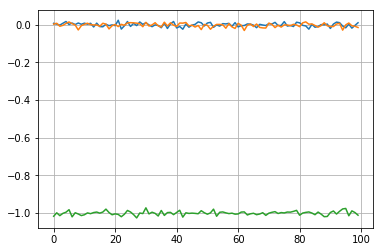

In [15]:
pts = []
for i in range(100):
    scale = 0.01
    m = np.array([scale*np.random.normal(), scale*np.random.normal(), -1+scale*np.random.normal()])
    pts.append(m)
plt.plot(pts)
plt.grid(True);

In [ ]:
np.random.normal()

In [ ]:
c = Calibraxis(True)
c.add_points(pts)
c.calibrate_accelerometer()
print('bias:', c.bias_vector)
print('scale:', c.scale_factor_matrix)

In [ ]:
c.apply((0,.05,-1.020))

In [ ]:
from __future__ import division
from scipy import optimize
# import random
# optimize.newton(kepler_eq, M, kepler_eq_der, args=(), tol=1e-10, maxiter=50)

In [ ]:
datasize = 30
s = .9
b = -.1
# ax = np.random.rand(datasize)
ax = [1.0+0.001*n for n in np.random.rand(datasize)]
am = [(s*x+b) for x in ax]

In [ ]:
plt.subplot(1,2,1)
plt.plot(range(datasize), ax);
plt.title('good data')
plt.xlabel('sample')
plt.ylabel('offsets')

plt.subplot(1,2,2)
plt.plot(range(datasize), am);
plt.title('noisey data')
plt.xlabel('sample')
plt.ylabel('offsets')

In [ ]:
# from math import sqrt

# def eqns(M, *args):
#     s = M[0]
#     b = M[1]
#     xx = args
# #     print('xx eqns', xx)
#     sum = 0
#     for x in xx:
# #         print('x', x)
#         sum += ((x - b)/2.0)**2 - 1.0
# #         print('sum', sum)
#     return sum

# def eqns_der(M, *args):
#     print('M', M)
#     s = M[0]
#     b = M[1]
#     xx = args
# #     print('xx', xx)
#     sum = 0
#     for x in xx:
# #         sum += np.array([-2*(x-b)**2*s**-3, -(x+2*b)/s**2])
#         sum += sqrt((-2*(x-b)**2*s**-3)**2 + (-(x+2*b)/s**2)**2)
# #     print('sum', sum)
#     return sum

# # optimize.newton(kepler_eq, M, kepler_eq_der, args=(), tol=1e-10, maxiter=50)
# optimize.newton(eqns, np.array([.7, .2]), eqns_der, args=tuple(am), tol=1e-10, maxiter=5)

In [ ]:
datasize = 30
s = .5
b = -.1
ax = [1.0+0.001*n for n in np.random.rand(datasize)]
am = [(s*x+b) for x in ax]

In [2]:
from __future__ import division
from scipy import optimize
import scipy.optimize as optimization

In [ ]:
def eqns(M, *args):
    s, b = M
#     print('args', args[0],type(args[0]))
    xx = args[0]
    err = np.sqrt(((xx - b)/s)**2) - 1.0
#     ret = sum(err)
    ret = err
#     print('ret', ret)
    return ret

def eqns_der(M, *args):
    s, b = M
    xx = args[0]
#     print('xx', type(xx))
    sdot = (2*(xx-b)**2)/(s**3)
    bdot = (xx+2.0*b)/(s**2)
    ret = np.vstack((sdot, bdot))
#     ret = np.array([sdot, bdot])
#     print(ret)
    return np.transpose(ret)

# optimization.leastsq(eqns, np.array([.7, .2]), args=(np.transpose(np.array(am))))
# optimization.leastsq(eqns, np.array([1.0, 1.0]), args=(np.transpose(np.array(am))), Dfun=eqns_der)
# optimization.leastsq(eqns, np.array([1.0, .04]), args=(np.array(am)))
optimization.leastsq(eqns, np.array([1.0, .01]), args=(np.array(am)), Dfun=eqns_der, full_output=False)

In [ ]:
sum(np.array([[1,2,3],[1,2,3]]))

In [ ]:
a=np.array([1,2,3])
-a

In [ ]:
aa,bb,cc = a

In [ ]:
sum(a)

In [ ]:
a.shape

In [ ]:
def eqns(M, *args):
    s, b = M
#     print('args', args[0],type(args[0]))
    xx = np.array(args)
    err = ((xx - b)/s)**2 - 1.0
    ret = float(sum(err))
#     ret = err
    print('ret eqns', ret, type(ret))
    return ret

def eqns_der(M, *args):
    s, b = M
    xx = np.array(args)
#     print('xx', type(xx))
    sdot = sum((2*(xx-b)**2)/(s**3))
    bdot = sum((xx+2.0*b)/(s**2))
#     ret = np.vstack((sdot, bdot))
#     ret = np.array([sdot, bdot])
#     print(ret)
#     ret = np.transpose(ret)
    ret = float(np.sqrt(sdot**2 + bdot**2))
    print('ret eqns_der', ret, type(ret))
    return ret

# optimize.newton(eqns, np.array([.7, .2]), eqns_der, args=tuple(np.array(am)), tol=1e-10, maxiter=5)
optimize.newton(eqns, np.array([.7, .2]), eqns_der, args=tuple(am), tol=1e-10, maxiter=5)

In [ ]:
type(np.array(am))

In [ ]:
np.array((1,2,3))

In [ ]:
optimize.newton(lambda x: x**2 - 1, x0=.2, fprime=lambda x: 2*x)

In [ ]:
optimize.newton(lambda x: x - 1, x0=.2, fprime=lambda x: 2*x)

In [ ]:
xx=[3*x+1 for x in range(10)]

def func(params, x, y):
    m, b = params
    err = ((m*x+b) - y)**2
    ret = sum(err)
    return 0.1

optimize.newton(func, x0=np.array([2,0]), args=np.transpose(np.array([xx, np.array(range(10))])))

In [ ]:
np.array(3*[1])

In [3]:
from numpy import arange, random
from numpy import pi, sin
from scipy.optimize import leastsq

In [ ]:
x = arange(0,6e-2,6e-2/30)
A,k,theta = 10, 1.0/3e-2, pi/6
print('k', k)
print('theta', theta)
y_true = A*sin(2*pi*k*x+theta)
y_meas = y_true + 2*np.random.randn(len(x))

print('true', type(y_true), 'meas', type(y_meas))

In [ ]:
def residuals(p, y, x):
    A,k,theta = p
    err = y-A*sin(2*pi*k*x+theta)
    return err

In [ ]:
p0 = [8, 1/2.3e-2, pi/3]
leastsq(residuals, p0, args=(y_meas, x))

In [27]:
"""
ier : int
        An integer flag.  If it is equal to 1, 2, 3 or 4, the solution was
        found.  Otherwise, the solution was not found. In either case, the
        optional output variable 'mesg' gives more information.
"""

x_true = np.array(30*[1])
S = 0.95
B = 0.0
# x_meas = S*x_true + B - 0.0001*np.random.randn(len(x_true))
x_meas = S*x_true + B

def residuals2(p, x):
    s, b = p
    err = np.sqrt(((x-b)/s)**2) - 1
    return err

def eqns_der(p, xx):
    s, b = p
    sdot = (-2.0*(xx-b)**2)/(s**3)
    bdot = (-xx+2.0*b)/(s**2)
#     sdot = -(xx-b)/(s**2)
#     bdot = -(xx-xx)/s
    ret = np.transpose((sdot, bdot))
    return ret

p0 = [1, 0.1]
leastsq(residuals2, p0, args=(x_meas), Dfun=eqns_der)
# leastsq(residuals2, p0, args=(x_meas))

(array([ 0.87608138,  0.0739186 ]), 2)

In [ ]:
1/1.4

In [38]:
def cal(data, p0):
    def residules(p, x):
        s, b = p
        err = np.sqrt(((x-b)/s)**2) - 1
        return err
    
    def res(p, x):
        return np.vstack((
            residules(p[0:2],x[0]),
            residules(p[2:4],x[1]),
            residules(p[4:6],x[2])
        ))

    def eqns_der(p, xx):
        s, b = p
        sdot = (-2.0*(xx-b)**2)/(s**3)
        bdot = (-xx+2.0*b)/(s**2)
    #     sdot = -(xx-b)/(s**2)
    #     bdot = -(xx-xx)/s
        ret = np.transpose((sdot, bdot))
        return ret
    
#     return leastsq(res, p0, args=data, Dfun=eqns_der)
    return leastsq(res, p0, args=data)
    
x_true = np.array(300*[1])
S = 0.95
B = 0.0
# x_meas = S*x_true + B - 0.0001*np.random.randn(len(x_true))
x_meas = S*x_true + B
meas = np.transpose((x_meas, x_meas, x_meas))

p0 = [1, 0.1,1, 0.1,1, 0.1]
cal(meas, p0)

TypeError: Improper input: N=6 must not exceed M=3

Estimated coefficients (true, linear regression, RANSAC):
82.1903908408 [ 54.17236387] [ 82.08533159]


Text(0,0.5,u'Response')

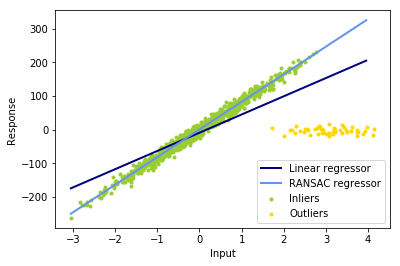

In [8]:
from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")

In [18]:
len(pts)

100

In [23]:
p = np.array(pts)
print(p[0])
p[:,1]

[ 0.00766663  0.00356293 -1.01768538]


array([  3.56292817e-03,   8.14519822e-03,  -8.07648488e-03,
        -3.09114445e-03,   6.84501107e-03,   1.51999486e-02,
         5.82224591e-03,  -1.30106954e-03,  -2.73967717e-02,
        -4.66845546e-03,   2.76871906e-03,   8.21585712e-03,
         7.82601752e-04,  -8.59307670e-04,  -1.15107468e-03,
        -7.82629156e-03,   8.20247837e-03,   3.38904125e-03,
        -2.20144129e-02,  -5.17519043e-03,   1.81338429e-03,
        -9.60504382e-03,   2.51484415e-03,  -2.75670535e-03,
         9.94394391e-03,   1.12859406e-02,   1.02943883e-02,
         8.62596011e-03,   5.53132064e-03,  -1.02993528e-02,
         1.29802197e-02,  -6.58552967e-03,  -7.78547559e-04,
         1.09634685e-02,  -5.81268477e-03,  -1.17915793e-02,
         1.37496407e-02,  -6.60056320e-03,   1.04797216e-02,
        -2.22605681e-03,  -8.88971358e-03,   9.36742464e-03,
         8.64052300e-03,   1.22487056e-02,  -5.85431204e-03,
        -2.02896841e-03,  -1.20857365e-02,  -3.84645423e-03,
        -2.55918467e-02,

In [24]:
X = p[:,0:1]
y = p[:,1]
# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.00766663  0.00355482 -0.00185054  0.00800298  0.01732721  0.00142062
  0.00929505  0.00123722  0.00943046  0.00269904  0.00868963  0.00314817
  0.00800565 -0.01159421  0.00875833 -0.00964612 -0.01054628  0.00279096
 -0.00468864 -0.00050604 -0.0043919   0.02412454 -0.0228862  -0.00539455
  0.01738873 -0.00882419  0.00771406 -0.00424318  0.01513328  0.00220508
  0.01100284 -0.00073925 -0.01018042 -0.00034242 -0.00347451 -0.01567768
  0.0089526  -0.01968625  0.0049869   0.01742669 -0.01681218 -0.0088872
 -0.02369587  0.00401499 -0.01279689 -0.00182245  0.0021348   0.01518261
  0.01078197 -0.00631904  0.00942468  0.01297846 -0.01347925 -0.00044595
 -0.00729045  0.00616887  0.00453782  0.00767902 -0.00805627  0.0113308
 -0.01139802 -0.00470638 -0.00392389  0.00439043  0.0035178  -0.00216731
 -0.01550429  0.00238103 -0.00110489 -0.00379148  0.0060512   0.00404762
  0.01285984 -0.00382009 -0.00375147  0.01670943 -0.00687299 -0.00370242
 -0.00918005  0.01359949  0.0103441  -0.00304964 -0.00600658 -0.02320594
  0.00225609 -0.01318396 -0.00932741  0.00097896 -0.00023423  0.00376877
 -0.01945703  0.00393063  0.01422983  0.01124419 -0.00656464 -0.01610878
  0.00330577 -0.01777667 -0.00346249  0.01081935].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.